<a href="https://www.kaggle.com/code/antongalysh/eda-ner?scriptVersionId=223370642" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Named Entity Recognition (NER) for Animal Tags

## Importing Required Libraries
This section imports necessary libraries such as NumPy, PyTorch, TorchCRF and Transformers(only for **tokenizer** and pretrained **BERT** model)

In [1]:
!pip install -q pytorch-crf

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from itertools import chain
import torch
from torchcrf import CRF
from torch import nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.nn.functional as F
from transformers import BertModel, AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Data Structure

### Data Format
The dataset is stored in a **Pandas DataFrame** with two primary columns:
- **`sentence`**: Contains the sentence or phrase where animal-related entities may appear.
- **`tags`**: A list of **BIO tags** (Beginning, Inside, Outside) corresponding to each word in the sentence.

#### Why Use BIO Tags?
- **B** (Beginning) is used to mark the first word of an entity (e.g., the first word of an animal name).
- **I** (Inside) marks subsequent words of the same entity (e.g., the following words of an animal name).
- **O** (Outside) marks words that do not belong to any entity.

The **BIO tagging scheme** is widely used for Named Entity Recognition (NER) tasks because it helps the model differentiate between the boundaries of entities and non-entities. This structure allows for **precise entity recognition** and is especially useful in contexts where entity names span multiple words.

### Tagging Structure

#### **Most Frequent Tags**:
- **O**: This tag represents **non-entity words** that do not belong to any named entity.
- **B-NOT_ANIMAL**: This tag is used when an entity is **not an animal**, but rather a **brand name**, **team name**, or other similar usage of animal names (e.g., "Tiger Technology", "Butterfly Lounge").
- **I-NOT_ANIMAL**: The continuation tag for **B-NOT_ANIMAL**. Used for multi-word entities where the name refers to something non-animal but uses animal names metaphorically (e.g., "Tiger Woods" in the context of a person or "Butterfly Tea" as a drink).

#### **Animal Tags**:
For all animal names, the tagging is consistent and follows the format:
- **B-ANIMAL**: The beginning of an animal name entity.
  
In the dataset, all animal tags are treated equally, ensuring **uniformity** in how animals are recognized regardless of the specific species or context.


In [3]:
df = pd.read_csv("/kaggle/input/animal-ner/ner_data.csv")
df['tags'] = df['tags'].apply(eval)

df.head()

,sentence,tags
0,The Beetle is sleeping.,"[O, B-BEETLE, O, O]"
1,The Butterfly is sleeping.,"[O, B-BUTTERFLY, O, O]"
2,The Cat is sleeping.,"[O, B-CAT, O, O]"
3,The Cow is sleeping.,"[O, B-COW, O, O]"
4,The Dog is sleeping.,"[O, B-DOG, O, O]"


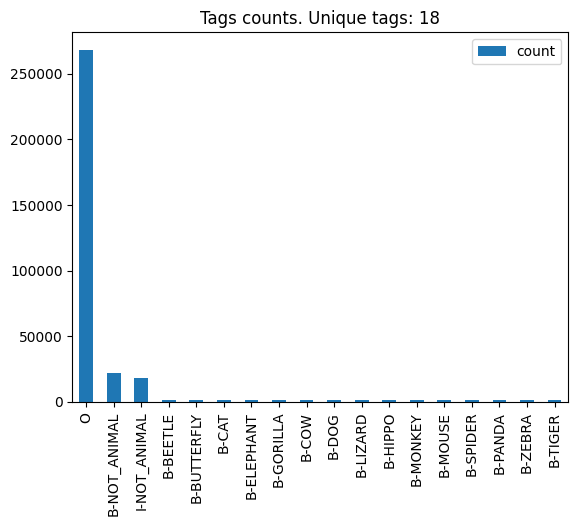

In [4]:
from collections import Counter

count = Counter()
for tags in df['tags']:
    count += Counter(tags)

df_count = pd.DataFrame(count.values(),
                        index=count.keys(),
                        columns=['count']
                        )
df_count.sort_values(by='count', inplace=True, ascending=False)

df_count.plot(kind='bar')
plt.title(f'Tags counts. Unique tags: {len(count)}')
plt.show()

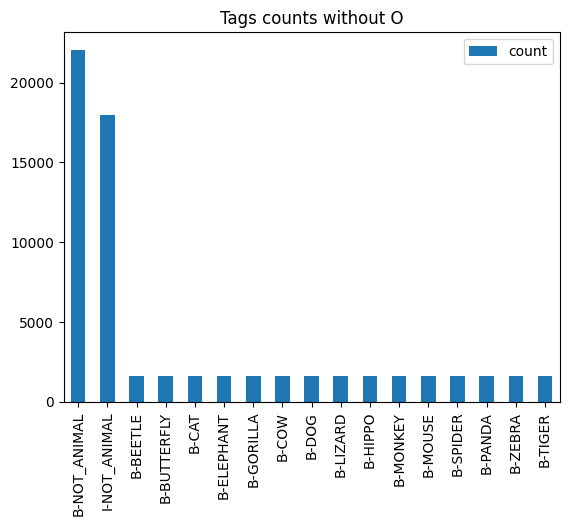

In [5]:
df_count_no_O = df_count.drop(index='O')

df_count_no_O.plot(kind='bar')
plt.title('Tags counts without O')
plt.show()

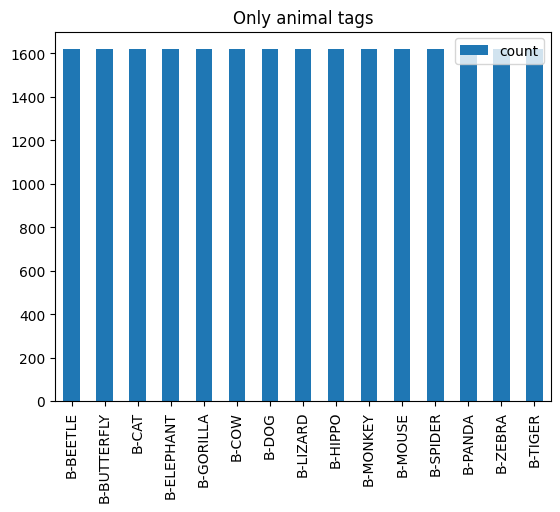

In [6]:
df_count_animals = df_count.drop(index=['O', 'B-NOT_ANIMAL', 'I-NOT_ANIMAL'])

df_count_animals.plot(kind='bar')
plt.title('Only animal tags')
plt.show()

## Tokenization and Sentence Token Count
Since we use a **tokenizer** to split sentences into tokens, it’s important to note that some words may be split into multiple tokens. This happens due to punctuation or compound words.

**Example:**
- **Sentence**: "It's my cat."
- **Tokens**: ["it", "'", "s", "my", "cat", "."]


To account for these splits, we need to calculate **token length** to avoid issues during model training. For this, the **token length should range between 7 and 27 tokens** per sentence.

This helps us select the **max_length** for padding or truncating the sequences during model preprocessing, ensuring that the model handles varying sentence lengths consistently.


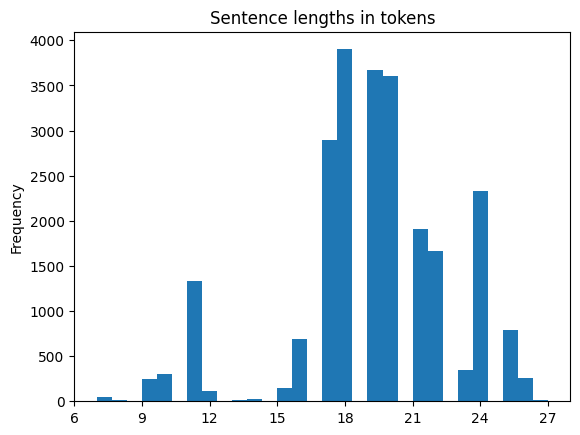

In [7]:
from matplotlib.ticker import MaxNLocator


def count_tokens(sent):
    encoding = tokenizer(
            sent.split(),
            is_split_into_words=True,
            return_offsets_mapping=False,
            truncation=True,
            return_tensors="pt"
        )

    return len(encoding['input_ids'][0])


token_lens = df['sentence'].apply(count_tokens)

ax = token_lens.plot(kind='hist', bins=30)
plt.title('Sentence lengths in tokens')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

## Model & Dataset Overview

### NERDataset Class: Data Transformation
The `NERDataset` class handles the following:
1. **Tokenization**: It tokenizes the text and aligns the tags with the words.
2. **Tag Alignment**: The tags are aligned with the word tokens after tokenization, ensuring that each token has a corresponding BIO tag. This is especially useful when tokenizers split words into multiple tokens (e.g., “it's” becoming ["it", "'", "s"]).
3. **Padding/Truncation**: The sentences are padded or truncated to match the `max_len` for consistent input to the model.

### The Problem: Tag Indexes for Special Tokens
When working with **Named Entity Recognition (NER)**, we use tokenizers that automatically insert special tokens like:
- **[PAD]** (Padding token)
- **[CLS]** (Start-of-sequence token)
- **[SEP]** (End-of-sequence token)

By default, these tokens do not correspond to any actual words in the sentence. Common practice in NER is to assign them the **index `-100`**, which allows the loss function (e.g., CrossEntropyLoss) to ignore them during training.

However, **this approach does not work for Conditional Random Fields (CRF)**, which require a valid tag index for every token.

### Why Attention Mask Doesn’t Help
One possible workaround is using **attention masks** to tell the model which tokens should be considered. However:
- **BERT requires the attention mask** to properly handle token importance.
- The CRF layer does **not** use the attention mask to ignore padding tokens.

This means that **we cannot rely on the attention mask to exclude special tokens from CRF processing**.

### The Solution: Label Special Tokens as `O` (Outside Tag)
To ensure compatibility with the CRF layer, we **assign the special tokens a tag index of `0`**, which corresponds to the `"O"` (Outside) tag in our label set. This allows:
- CRF to process all tokens without encountering invalid indices.
- Special tokens to have minimal impact on the learning process.

### NERBert Model: BERT + CRF

The core model used for NER is based on **BERT (Bidirectional Encoder Representations from Transformers)**, enhanced with a **CRF (Conditional Random Field)** layer for sequence labeling.

### Why BERT?
BERT is a pre-trained transformer model that has shown exceptional performance in natural language processing tasks. It captures deep contextual relationships between words, which is vital for understanding complex relationships in NER tasks, such as distinguishing between animal names and non-animal entities.

### Why CRF?
The **CRF layer** is added on top of BERT's hidden states to model the sequence of labels for NER tasks. The CRF is beneficial because:
- It explicitly models dependencies between consecutive tags, ensuring that the predictions for each token are coherent across the sequence.
- For example, **“Tiger Technology”** should be tagged as **B-NOT_ANIMAL** and **I-NOT_ANIMAL**, not as **B-ANIMAL** and **B-NOT_ANIMAL**.

### Model Architecture
- **BERT Backbone**: The model uses **BERT-base-uncased** for feature extraction, which is frozen during training (no gradients are calculated for its parameters).
- **Linear Classifier**: A linear layer maps BERT's hidden state to the number of tags.
- **CRF Layer**: This layer decodes the sequence of labels and ensures smooth, valid label sequences.

### NER Model Wrapper: Training and Prediction

The `NER` class wraps the model for training and inference, and it provides utility methods to handle the training process and predictions.

### Training: `train(dataset)`
- The model is trained using a **DataLoader** that fetches batches of tokenized text and corresponding tags.
- **Optimizer**: Adam is used for parameter updates.
- **Loss Function**: The loss is computed using the **CRF** layer, which optimizes for both tag accuracy and sequence coherence.

### Prediction: `predict(text)`
- The `predict` method transforms the input sentence, passes it through the trained model, and decodes the predicted tags.
- The output is a list of **tags** corresponding to each word in the input sentence.
  
### Model Persistence: `save` and `load`
- **`save`**: The trained model and tag mappings are saved to disk.
- **`load`**: The saved model weights and tag mappings are loaded for inference.

In [8]:
class NERDataset(Dataset):
    def __init__(self, texts, tags, tokenizer, max_len=30):
        self.texts = texts
        self.tags = tags
        self.tokenizer = tokenizer
        self.max_len = max_len

        unique_tags = set()
        for tags in tags:
            unique_tags |= set(tags)

        self.unique_tags = None
        self.tags_to_ids = None
        self.set_tags(list(unique_tags))

    def get_tag(self, idx):
        return self.unique_tags[idx]

    def set_tags(self, tags):
        self.unique_tags = tags

        self.unique_tags.remove('O')
        self.unique_tags.insert(0, 'O')

        self.tags_to_ids = {tag: i for i, tag in enumerate(self.unique_tags)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tags = self.tags[idx]

        return self.transform(text, tags)

    def transform(self, text, tags=None):
        encoding = self.tokenizer(
            text.split(),
            is_split_into_words=True,
            return_offsets_mapping=False,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        aligned_tags = self.transform_tags(encoding, tags)

        return input_ids, attention_mask, aligned_tags


    def transform_tags(self, encoding, tags):
        if tags is None:
            return None

        word_ids = encoding.word_ids()
        aligned_tags = []
        tag_num = -1
        prev_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                aligned_tags.append(0)
            elif word_idx != prev_word_idx:
                tag_num += 1
                tag = tags[tag_num]
                tag_id = self.tags_to_ids.get(tag, 0)
                aligned_tags.append(tag_id)
            else:
                tag = tags[tag_num]
                tag_id = self.tags_to_ids.get(tag, 0)
                aligned_tags.append(tag_id)

            prev_word_idx = word_idx

        return torch.tensor(aligned_tags, dtype=torch.long)


class NERBert(nn.Module):
    def __init__(self, num_tags):
        super().__init__()
        self.num_tags = num_tags

        self.bert = BertModel.from_pretrained("bert-base-uncased")

        for param in self.bert.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(self.bert.config.hidden_size, num_tags)
        self.crf = CRF(num_tags, batch_first=True)

    def forward(self, input_ids, mask, tags=None):
        outputs = self.bert(input_ids, attention_mask=mask)
        emissions = self.classifier(outputs.last_hidden_state)

        if tags is not None:
            return -self.crf(emissions, tags,
                             mask=mask.bool(),
                             reduction="mean")
        else:
            return self.crf.decode(emissions, mask=mask.bool())

class NER:
    def __init__(self, num_tags=18, **kwargs):
        self.num_tags = num_tags
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.model = NERBert(num_tags)
        self.model = self.model.to(self.device)

        self.epochs = kwargs.get('epochs', 10)
        self.batch_size = kwargs.get('batch', 32)
        self.lr = kwargs.get('lr', 1e-3)

        self.dataset = None

    def train(self, dataset):
        self.dataset = dataset

        dataloader = DataLoader(dataset,
                                batch_size=self.batch_size,
                                shuffle=True
                                )

        optimizer = Adam(self.model.parameters(),
                         lr=self.lr
                         )

        self.model.train()

        losses = []
        for _ in range(self.epochs):
            loss_ = []
            for input_ids, mask, tags in dataloader:
                input_ids = input_ids.to(self.device)
                mask = mask.to(self.device)
                tags = tags.to(self.device)

                loss = self.model(input_ids, mask, tags)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss_.append(loss.item())
            losses.append(np.mean(loss_))
            print(losses[-1])
        return losses

    def predict(self, text):
        if self.dataset is None:
            raise Exception("model isn't trained")

        input_ids, mask, _ = self.dataset.transform(text)

        input_ids = input_ids.unsqueeze(0)
        mask = mask.unsqueeze(0)

        self.model.eval()

        with torch.no_grad():
            input_ids = input_ids.to(self.device)
            mask = mask.to(self.device)

            preds = self.model(input_ids, mask)
            preds = preds[0]

            tags = [self.dataset.get_tag(idx) for idx in preds]

            return tags

    def save(self, model_path, tags_path):
        """
        Saves the trained model and label mappings to files

        Args:
            model_path (str):
                file path to save the model
        """
        torch.save(self.model.state_dict(), model_path)

        with open(tags_path, 'w') as file:
            json.dump(self.dataset.unique_tags, file)

    def load(self, model_path, tags_path):
        """
        Loads a trained model and label mappings from files

        Args:
            model_path (str):
                file path of the saved model
        """
        weights = torch.load(model_path, weights_only=True,
                             map_location=self.device)
        self.model.load_state_dict(weights)
        self.model = self.model.to(self.device)

        with open(tags_path) as file:
            tags = json.load(file)

        dataset = NERDataset(['it'], ['O'], tokenizer)
        dataset.set_tags(tags)

        self.dataset = dataset


In [9]:
dataset = NERDataset(df['sentence'], df['tags'], tokenizer)


### Final Performance Metrics
- **Negative Log-Likelihood (NLL) from CRF**: `0.3`  
  - The lower the NLL, the better the model is at predicting sequences correctly. A value of `-0.3` indicates that the model has learned strong structured dependencies in the data.  

- **Accuracy**: `99.8%`  
  - The model achieves near-perfect accuracy, meaning it correctly identifies almost all entity tags in the dataset.  

---

### Observations & Mismatches  
- Some mismatches occur between the **"O" (Outside) tag** and other entity tags.  
- This is **expected behavior** in NER models, as boundary classification between entity tokens and non-entity tokens can be challenging.  
- Despite this, the overall accuracy remains high, and the impact on real-world applications should be minimal.  

---

### Conclusion  
The **BERT-CRF NER model** performs exceptionally well on the dataset, achieving **high accuracy and low NLL loss**.  
Minor misclassifications on `"O"` tags are expected but do not significantly impact overall model reliability.

In [10]:
data = {'epochs': 30, 'batch': 256, 'lr': 1e-3}
model = NER(**data)
# model.load('ner_model.pt', 'tags.json')

losses=model.train(dataset)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

13.94071965970491
4.890038771378366
3.4931187780279864
2.8201461515928568
2.4012394202382943
2.082298089328565
1.8355414014113576
1.6364735929589522
1.4717601876509816
1.3285884242308768
1.196459224349574
1.0969463097421746
1.0045812694649947
0.9193038557705127
0.8513734698295593
0.780315719780169
0.7203610031228317
0.6658423492782994
0.620342094647257
0.5767910913417214
0.5377550523532064
0.5019418057642485
0.4714986195689754
0.44167210647934363
0.4143767984289872
0.38978773073146217
0.36786101491827716
0.3446463290013765
0.32645042475901154
0.3100502478448968


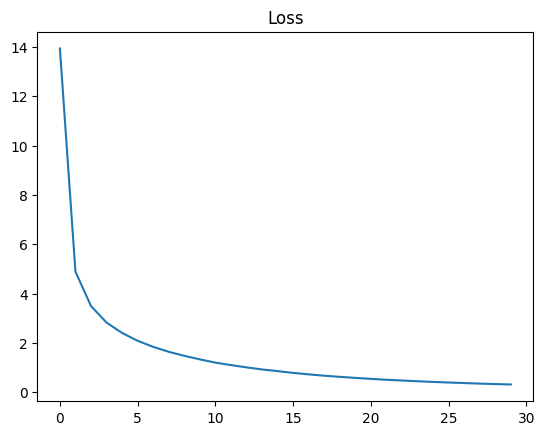

In [12]:
plt.title('Loss')
plt.plot(losses)

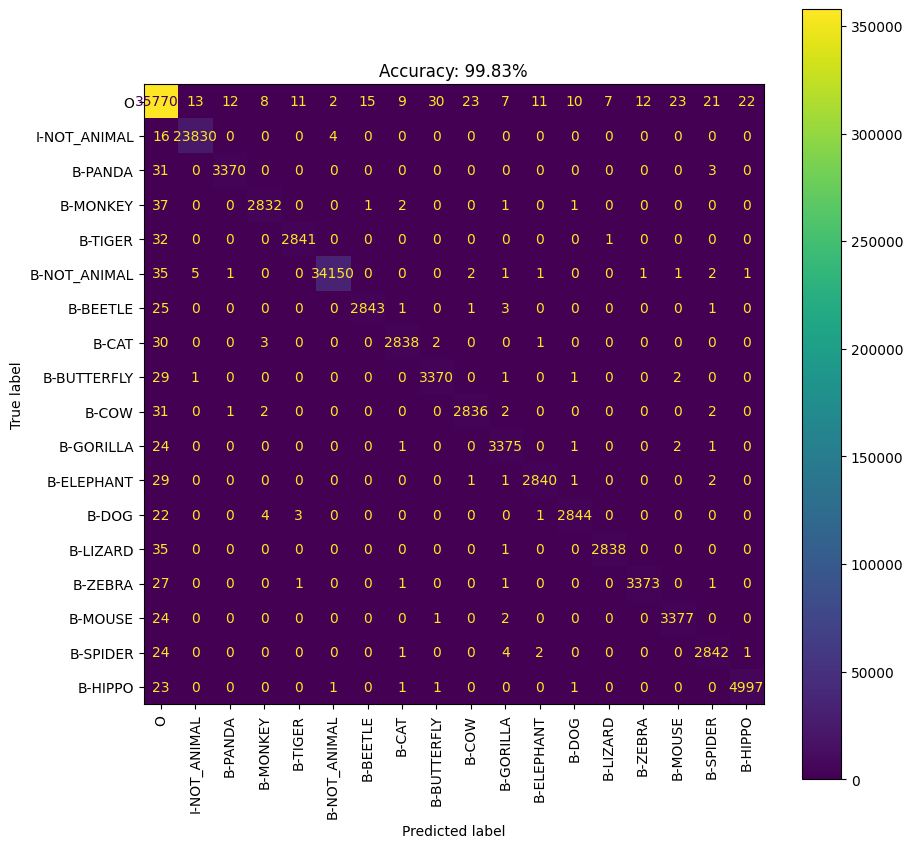

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

y_pred = []
y_true = []


for input_ids, mask, tags in dataset:
    preds = model.model(input_ids.unsqueeze(0).to('cuda'), mask.unsqueeze(0).to('cuda'))
    preds = preds[0]

    length = len(preds)

    y_true.extend(tags.numpy()[:length])
    y_pred.extend(preds)


acc = accuracy_score(y_true, y_pred)*100

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                        display_labels=dataset.unique_tags,
                                        ax=ax)

plt.title(f"Accuracy: {acc:0.2f}%")
plt.xticks(rotation=90)
plt.show()

In [34]:
model.predict("He is a bit of a tiger, always trying to trick you like cat do in zoo.")

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-NOT_ANIMAL',
 'B-NOT_ANIMAL',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-CAT',
 'O',
 'O',
 'O',
 'O',
 'O']

In [35]:
model.predict("I went to Tiger Motors shop with my cat")

['O',
 'O',
 'O',
 'O',
 'B-NOT_ANIMAL',
 'I-NOT_ANIMAL',
 'O',
 'O',
 'O',
 'B-CAT',
 'O']

In [37]:
model.save('ner_model.pt', 'tags.json')